In [2]:
!pip install pandas
!pip install -U pip
!pip install -U matplotlib
!pip install fire

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 27.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 KB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 KB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 22.0.2
    Not uninstalling pip at /usr/lib/python3/dist-packages, outside environment /usr
    Can't uninstall 'pip'. No files were found to uninstall.
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114262 sha256=dcd4b35fc657d4b07e8d6c04a9dbdce469b7922ad796996a4b490a3bcaf8de74
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [13]:
!ls ../Data

2D_darcy_mixed_formulation_eq_Dirichlet_BC.csv
2D_poisson_eq_Dirichlet_BC.csv
32x32_2D_poisson_eq_Dirichlet_BC.csv
32x32_2D_poisson_eq_Dirichlet_BC2.csv
3D_darcy_mixed_formulation_eq_Dirichlet_BC.csv
64x64_2D_poisson_eq_Dirichlet_BC.csv
64x64_2D_poisson_eq_Dirichlet_BC2.csv
64x64_2D_poisson_eq_Dirichlet_BC3.csv
64x64_2D_poisson_eq_Dirichlet_BC4.csv
64x64_2D_poisson_eq_Dirichlet_BC5.csv
64x64_2D_poisson_eq_Dirichlet_BC6.csv
64x64_2D_poisson_eq_Dirichlet_BC_V_BC_H.csv
64x64_2D_poisson_eq_Dirichlet_DBC_V_NBC_H.csv


# Data preprocessing debug

In [5]:
import torch
import pandas as pd
import sys

sys.path.append("../DL_models")
sys.path.append("..")


In [6]:
data=pd.read_csv("../Data/64x64_2D_poisson_eq_Dirichlet_BC.csv")


In [7]:
data["U"]=data.apply(lambda d: np.hstack((data.sample(n=4,replace=True)["u"].values,d["u"])) ,axis=1)
#np.vstack(data.sample(n=4,replace=True)["u"].values)


In [13]:
data=data.apply(
data.sample(n=5,replace=True)

,Unnamed: 0,u,x,y,z,t,U
1307,1307,1.407227,0.531250,0.250000,0.0,NaN,"[[[2.877929687499999, 2.3300781249999973, 2.02..."
2375,2375,1.752686,0.703125,0.359375,0.0,NaN,"[[[1.6108398437499982, 1.2268066406250275, 1.3..."
252,252,1.215576,0.015625,0.328125,0.0,NaN,"[[[1.1701660156250175, 3.37133789062499, 1.510..."
3507,3507,2.431152,0.781250,0.640625,0.0,NaN,"[[[2.59814453125, 1.5356445312500089, 1.568359..."
3254,3254,2.379395,0.625000,0.703125,0.0,NaN,"[[[1.610839843750042, 2.141113281250059, 2.674..."


# Models debug

In [1]:
import torch
import pandas as pd
import sys

sys.path.append("../DL_models")
sys.path.append("..")

from Models.GAN import *
from Models.PointNet import *

In [2]:
from Train import Trainer

### Poisson 2D
$$-\nabla^2 u(\mathbf{x})=f(\mathbf{x}) \ \mathbf{x} \in \Omega$$
$$u(\mathbf{x})=u_D(\mathbf{x}) \ \mathbf{x} \in \Omega$$

$$\mathbf{x}=[x,y] \ \Omega: [0,1]\times[0,1]$$

$$u_D(x,y)=1+x^2+2y^2$$
$$f(x,y)=-6$$

$$\Theta=[x,y]$$

In [6]:
def derivatives(u,x,n):
    if n==0:
        return u
    else:
        du=torch.autograd.grad(u,x,
        grad_outputs=torch.ones_like(u).to('cpu'),
        create_graph=True,
        retain_graph=True,
        allow_unused=True
        )[0]
    return derivatives(du,x,n-1)


M=GAN_PI(
    G_params={"layers":[3,50,50,50,1],"activators":[torch.nn.Tanh(),torch.nn.Tanh(),torch.nn.Tanh(),torch.nn.Identity()]},
    P_params={"layers":[3,50,50,50,1],"activators":[torch.nn.Tanh(),torch.nn.Tanh(),torch.nn.Tanh(),torch.nn.Identity()]},
    D_params={"layers":[1,50,50,1],"activators":[torch.nn.LeakyReLU(),torch.nn.LeakyReLU(),torch.nn.Identity()]},
    args_Gen={"W_posterior":1.5},
    args_PDE_res={
        "R":(lambda u,x:-1*(derivatives(u,x,2)[:,0]+derivatives(u,x,2)[:,1])),
        "f":(lambda u,x:1+x[:,0]**2+2*x[:,1]**2),
        "norm":lambda x:torch.mean(torch.abs(x))
    },
    args_PDE_sup={
        "norm":lambda x:torch.sum(torch.abs(x))
    },
    distribution_args={"mean":torch.tensor([[0.0]]), "std":torch.tensor([[1.0]])}
)

In [14]:
eval('[torch.nn.Tanh(),\
torch.nn.Tanh(),torch.nn.Tanh(),torch.nn.Identity()]')

[Tanh(), Tanh(), Tanh(), Identity()]

In [19]:
eval("{'layers':[3,50,50,50,1],'activators':[torch.nn.Tanh(),torch.nn.Tanh(),torch.nn.Tanh(),torch.nn.Identity()]}")

{'layers': [3, 50, 50, 50, 1],
 'activators': [Tanh(), Tanh(), Tanh(), Identity()]}

In [15]:
import json

In [ ]:
j

In [13]:
optimizer=torch.optim.Adam(M.parameters(),lr=0.00005)
TT=Trainer(model_instance=M,data_path="../Data/2D_poisson_eq_Dirichlet_BC.csv",batch_size=200,optimizer=optimizer)

In [24]:
epoch_losses=[]
for i in range(1000):
    losses=TT.train()
    epoch_losses.append(losses)

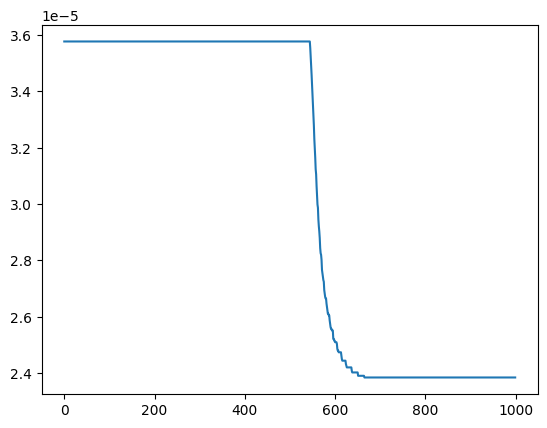

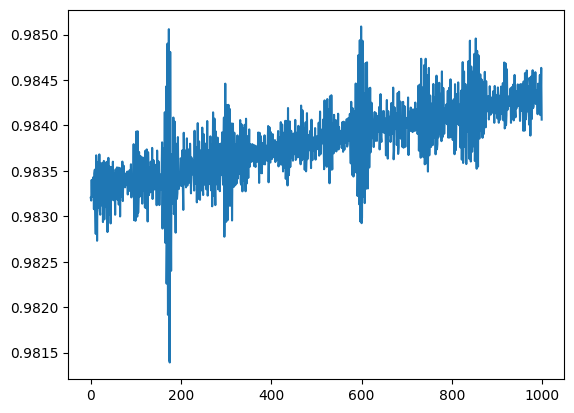

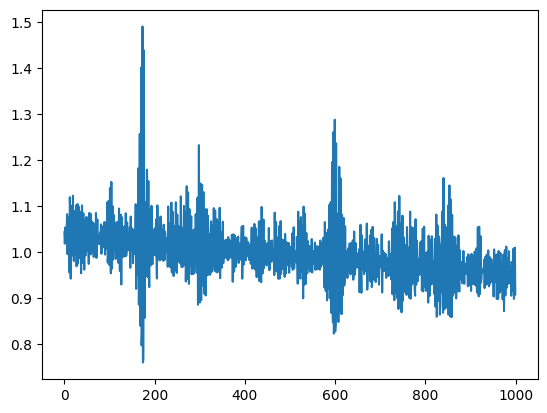

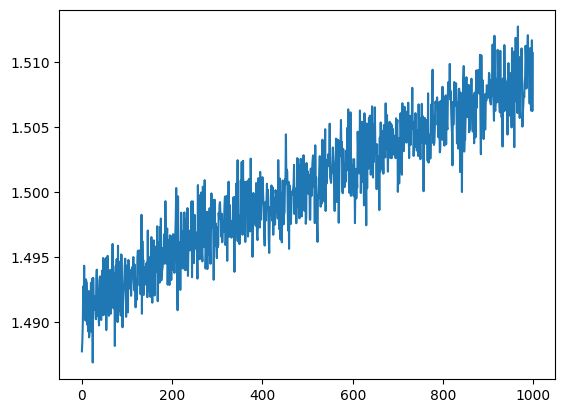

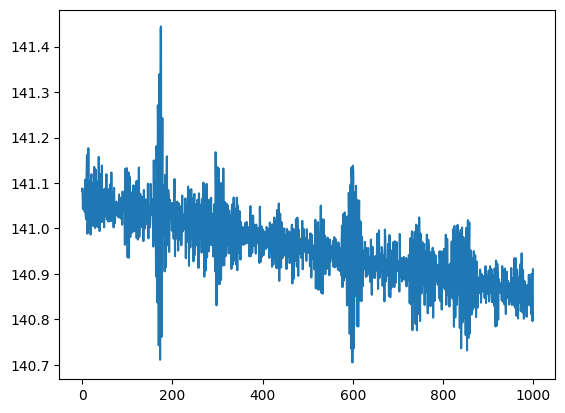

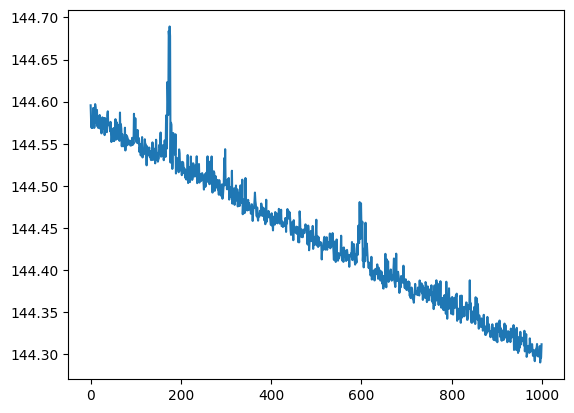

In [25]:
import matplotlib.pyplot as plt
from functools import reduce
losses=reduce(lambda x,y:x+y, epoch_losses)
plt.plot(list(map(lambda l:l["generative_posterior_loss"].cpu().detach().numpy(),losses)))
plt.figure()
plt.plot(list(map(lambda l:l["generative_entropy_loss"].cpu().detach().numpy(),losses)))
plt.figure()
plt.plot(list(map(lambda l:l["Discriminator_loss"].cpu().detach().numpy(),losses)))
plt.figure()
plt.plot(list(map(lambda l:l["PDE_residual_loss"].cpu().detach().numpy(),losses)))
plt.figure()
plt.plot(list(map(lambda l:l["PDE_supervised_loss"].cpu().detach().numpy(),losses)))
plt.figure()
plt.plot(list(map(lambda l:l["total_loss"].cpu().detach().numpy(),losses)))

epoch_losses

# Phasiclearning

In [4]:
from Train import Dual_optimizer_trainer

In [187]:
M=GAN_PI(
    G_params={"layers":[3,10,10,10,1],"activators":[torch.nn.Tanh(),torch.nn.Tanh(),torch.nn.Tanh(),torch.nn.Identity()]},
    P_params={"layers":[3,10,10,10,1],"activators":[torch.nn.Tanh(),torch.nn.Tanh(),torch.nn.Tanh(),torch.nn.Identity()]},
    D_params={"layers":[1,10,10,1],"activators":[torch.nn.LeakyReLU(),torch.nn.LeakyReLU(),torch.nn.Identity()]},
    args_Gen={"W_posterior":1.5},
    args_PDE_res={
        "R":(lambda u,x:-1*(derivatives(u,x,2)[:,0]+derivatives(u,x,2)[:,1])),
        "f":(lambda u,x:1+x[:,0]**2+2*x[:,1]**2),
        "norm":lambda x:torch.mean(torch.abs(x))
    },
    args_PDE_sup={
        "norm":lambda x:torch.sum(torch.abs(x))
    },
    distribution_args={"mean":torch.tensor([[0.0]]), "std":torch.tensor([[1.0]])}
)

In [188]:
T=Dual_optimizer_trainer(model_instance=M,
                       data_path="../Data/2D_poisson_eq_Dirichlet_BC.csv",
                       batch_size=200,
                       optimizers=(
                           torch.optim.Adam(M.D_model.parameters(),lr=1e-4),
                            torch.optim.Adam(list(M.G_model.parameters())+list(M.P_model.parameters()),lr=1e-4)
                            ),
                       sub_steps=(1,5)
                      )

In [229]:
#T.batch_size
epoch_losses=[]
for i in range(100):
    losses=T.train()
    epoch_losses.append(losses)

d_losses=list(map(lambda l:l[0],epoch_losses))
g_losses=list(map(lambda l:l[1],epoch_losses))

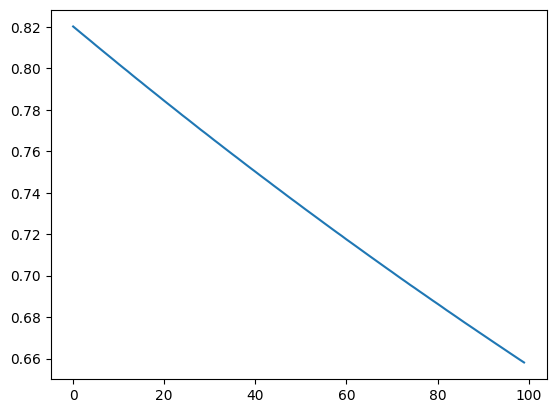

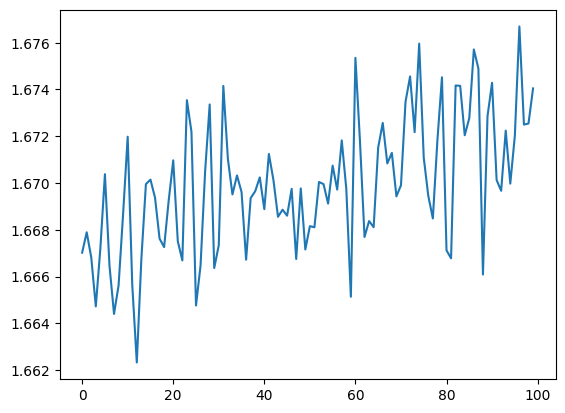

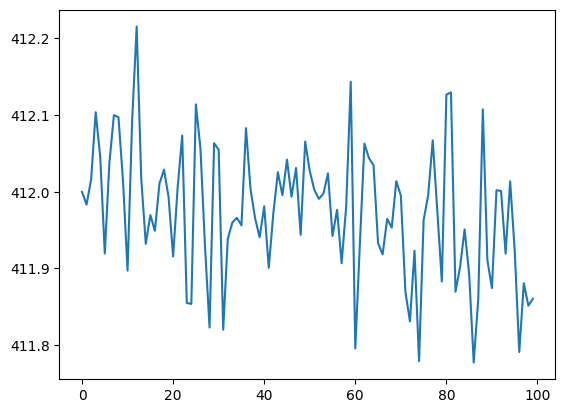

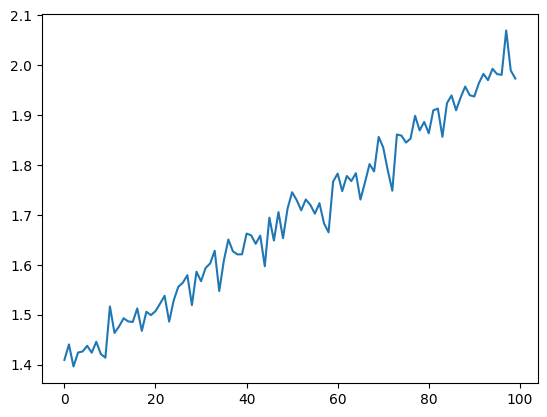

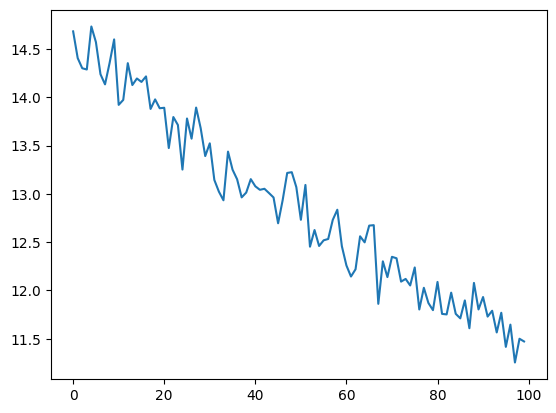

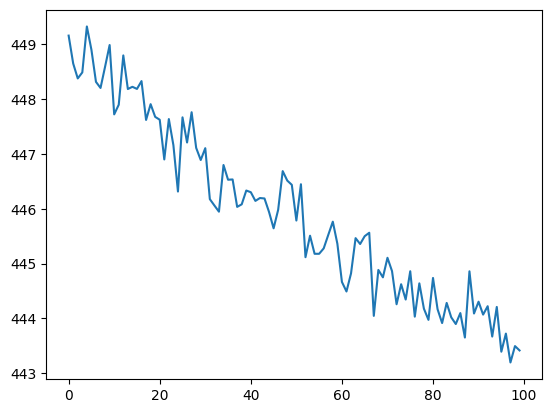

In [230]:
#epoch_losses

import matplotlib.pyplot as plt
from functools import reduce
losses=reduce(lambda x,y:x+y, d_losses)
plt.plot(list(map(lambda l:l["generative_posterior_loss"].cpu().detach().numpy(),losses)))
plt.figure()
plt.plot(list(map(lambda l:l["generative_entropy_loss"].cpu().detach().numpy(),losses)))
plt.figure()
plt.plot(list(map(lambda l:l["Discriminator_loss"].cpu().detach().numpy(),losses)))
plt.figure()
plt.plot(list(map(lambda l:l["PDE_residual_loss"].cpu().detach().numpy(),losses)))
plt.figure()
plt.plot(list(map(lambda l:l["PDE_supervised_loss"].cpu().detach().numpy(),losses)))
plt.figure()
plt.plot(list(map(lambda l:l["total_loss"].cpu().detach().numpy(),losses)))

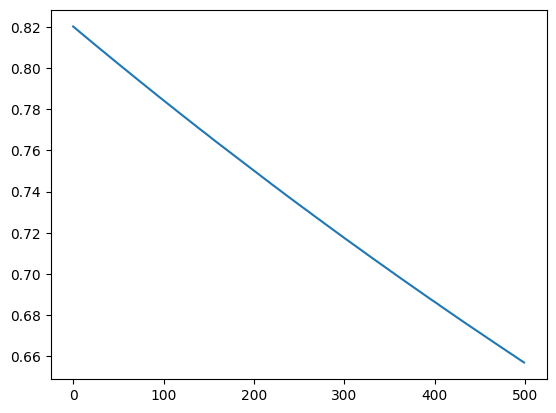

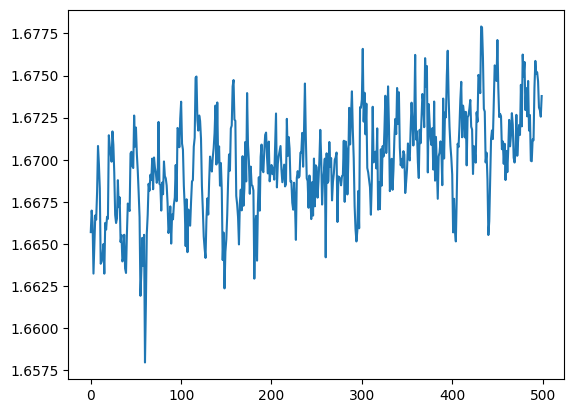

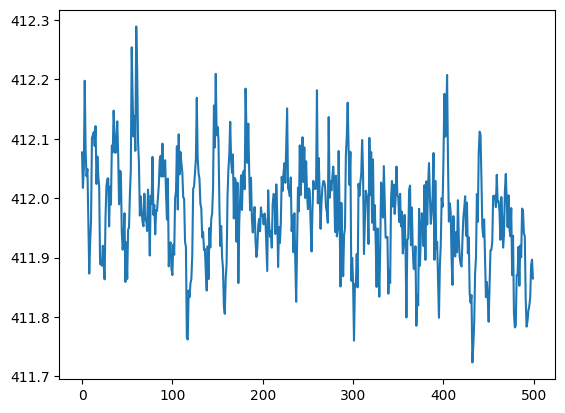

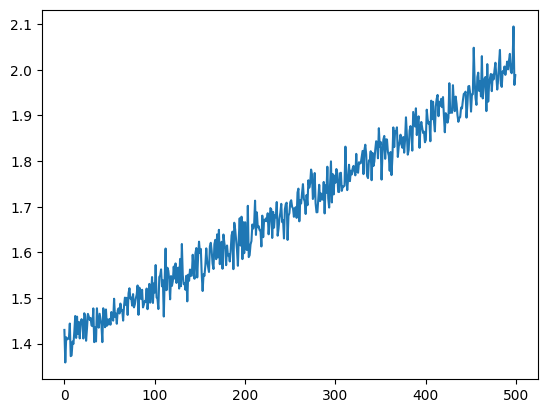

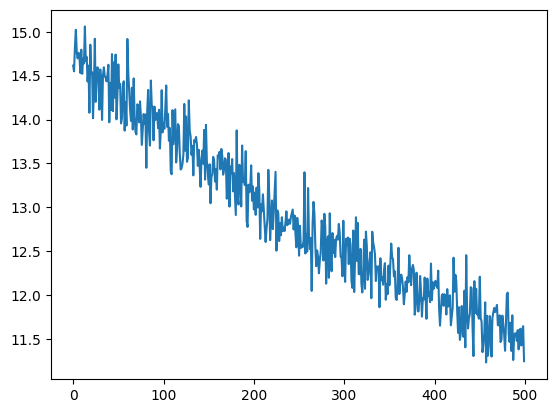

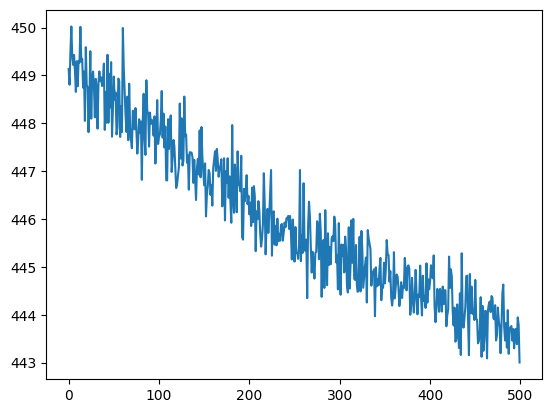

In [231]:
import matplotlib.pyplot as plt
from functools import reduce
losses=reduce(lambda x,y:x+y, g_losses)
plt.plot(list(map(lambda l:l["generative_posterior_loss"].cpu().detach().numpy(),losses)))
plt.figure()
plt.plot(list(map(lambda l:l["generative_entropy_loss"].cpu().detach().numpy(),losses)))
plt.figure()
plt.plot(list(map(lambda l:l["Discriminator_loss"].cpu().detach().numpy(),losses)))
plt.figure()
plt.plot(list(map(lambda l:l["PDE_residual_loss"].cpu().detach().numpy(),losses)))
plt.figure()
plt.plot(list(map(lambda l:l["PDE_supervised_loss"].cpu().detach().numpy(),losses)))
plt.figure()
plt.plot(list(map(lambda l:l["total_loss"].cpu().detach().numpy(),losses)))

In [232]:

UU_=[]
for i in range(50):
    U_=[]
    for x in T.data.X:
        u_=M.Generate_forward(torch.tensor(np.array(x),dtype=torch.float).unsqueeze(0))
        U_.append(u_.detach().numpy()[0,0])
    UU_.append(np.array(U_).reshape(-1,17))

In [233]:
U_m=np.mean(np.stack(UU_,axis=0),axis=0)
U_s=np.std(np.stack(UU_,axis=0),axis=0)

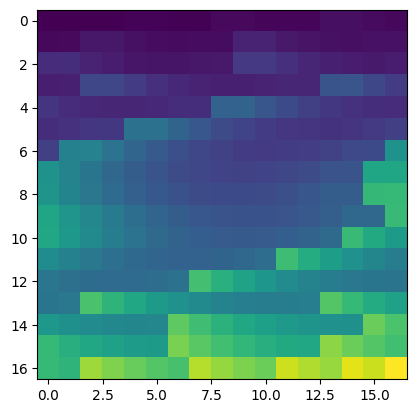

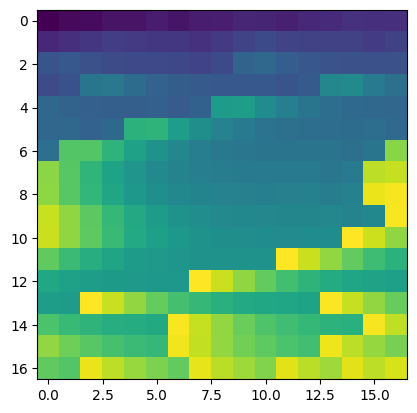

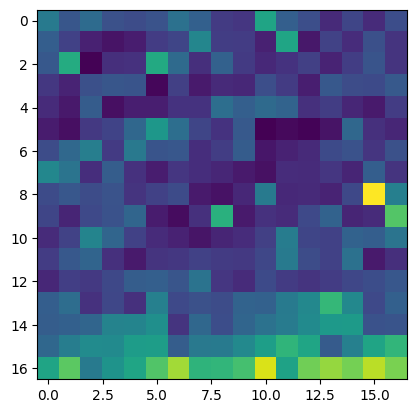

In [234]:
plt.imshow(T.data.U.values.reshape(-1,17))
plt.figure()
plt.imshow(U_m)
plt.figure()
plt.imshow(U_s)
#T.data.U.values.shape[0]**0.5

In [186]:
U_s

array([[0.00039533, 0.00032101, 0.00040067, 0.00115975, 0.00041598,
        0.00038825, 0.00057866, 0.00102104, 0.00035962, 0.00043326,
        0.00036969, 0.00135649, 0.00091238, 0.00024209, 0.00061362,
        0.00072967, 0.0009321 ],
       [0.00148983, 0.00118149, 0.00021572, 0.00021275, 0.00056636,
        0.00103046, 0.00140937, 0.0010872 , 0.00061152, 0.0002716 ,
        0.00034563, 0.00040727, 0.00100831, 0.00050971, 0.00107181,
        0.00132317, 0.00118049],
       [0.0003703 , 0.00037547, 0.00041721, 0.00071853, 0.00115098,
        0.00130878, 0.00171572, 0.00108129, 0.00125378, 0.00051045,
        0.00021069, 0.00031233, 0.00059454, 0.00084732, 0.00135796,
        0.00155406, 0.0017914 ],
       [0.0007878 , 0.00094299, 0.00062948, 0.00029072, 0.00028983,
        0.00059409, 0.00100136, 0.00089254, 0.00118164, 0.00109612,
        0.00124057, 0.00071949, 0.00071674, 0.00093491, 0.00046128,
        0.00011598, 0.00082369],
       [0.00075308, 0.00144686, 0.00173365, 0.001580

# Epochs

In [1]:
import torch
import pandas as pd
import sys

sys.path.append("../DL_models")
sys.path.append("..")

from Models.GAN import *

def derivatives(u,x,n):
    if n==0:
        return u
    else:
        du=torch.autograd.grad(u,x,
        grad_outputs=torch.ones_like(u).to('cpu'),
        create_graph=True,
        retain_graph=True,
        allow_unused=True
        )[0]
    return derivatives(du,x,n-1)

In [2]:
from Train import Dual_optimizer_trainer

In [3]:
M=GAN_PI(
    G_params={"layers":[3,10,10,10,1],"activators":[torch.nn.Tanh(),torch.nn.Tanh(),torch.nn.Tanh(),torch.nn.Identity()]},
    P_params={"layers":[3,10,10,10,1],"activators":[torch.nn.Tanh(),torch.nn.Tanh(),torch.nn.Tanh(),torch.nn.Identity()]},
    D_params={"layers":[1,10,10,1],"activators":[torch.nn.LeakyReLU(),torch.nn.LeakyReLU(),torch.nn.Identity()]},
    args_Gen={"W_posterior":1.5},
    args_PDE_res={
        "R":(lambda u,x:-1*(GAN_PI.derivatives(u,x,2)[:,0]+GAN_PI.derivatives(u,x,2)[:,1])),
        "f":(lambda u,x:1+x[:,0]**2+2*x[:,1]**2),
        "norm":lambda x:torch.mean(torch.abs(x))
    },
    args_PDE_sup={
        "norm":lambda x:torch.sum(torch.abs(x))
    },
    distribution_args={"mean":torch.tensor([[0.0]]), "std":torch.tensor([[1.0]])}
)

PINNS_init


In [7]:
torch.tensor([1]).device

device(type='cpu')

In [4]:


T=Dual_optimizer_trainer(model_instance=M,
                       data_path="../Data/2D_poisson_eq_Dirichlet_BC.csv",
                       batch_size=50,
                       optimizer=(
                           torch.optim.Adam(M.D_model.parameters(),lr=1e-4),
                            torch.optim.Adam(list(M.G_model.parameters())+list(M.P_model.parameters()),lr=1e-4)
                            ),
                       sub_steps=(1,5),
                    data_dir="../../exps",
                    scope_agent="generative_losses",
                    scope_loss="PDE_supervised_loss"
                      )

In [5]:
losses=T.epochs_train_test(10)

  0%|                                                                                                                                | 0/10 [00:00<?, ?it/s]


TypeError: PINN_base.derivatives() missing 1 required positional argument: 'n'

In [9]:
losses[3]["test"]["discriminative_losses"]

[{'generative_entropy_loss': tensor(0.0959),
  'generative_posterior_loss': tensor(13.4877),
  'PDE_residual_loss': tensor(1.1435),
  'PDE_supervised_loss': tensor(53.1958),
  'Discriminator_loss': tensor(104.0247),
  'Generator_loss': tensor(16.9807),
  'total_loss': tensor(188.9283)},
 {'generative_entropy_loss': tensor(0.0982),
  'generative_posterior_loss': tensor(13.4354),
  'PDE_residual_loss': tensor(1.4991),
  'PDE_supervised_loss': tensor(70.8072),
  'Discriminator_loss': tensor(118.1165),
  'Generator_loss': tensor(21.4600),
  'total_loss': tensor(225.4164)},
 {'generative_entropy_loss': tensor(0.1061),
  'generative_posterior_loss': tensor(13.4171),
  'PDE_residual_loss': tensor(1.8578),
  'PDE_supervised_loss': tensor(88.3829),
  'Discriminator_loss': tensor(133.2275),
  'Generator_loss': tensor(25.9410),
  'total_loss': tensor(262.9324)},
 {'generative_entropy_loss': tensor(0.1220),
  'generative_posterior_loss': tensor(13.4030),
  'PDE_residual_loss': tensor(2.1902),
  'P

In [10]:
losses

{0: {'test': {'discriminative_losses': [{'generative_entropy_loss': tensor(0.0129),
     'generative_posterior_loss': tensor(14.5030),
     'PDE_residual_loss': tensor(1.1504),
     'PDE_supervised_loss': tensor(57.3455),
     'Discriminator_loss': tensor(106.0530),
     'Generator_loss': tensor(18.2529),
     'total_loss': tensor(197.3177)},
    {'generative_entropy_loss': tensor(0.0173),
     'generative_posterior_loss': tensor(14.4863),
     'PDE_residual_loss': tensor(1.5060),
     'PDE_supervised_loss': tensor(74.8525),
     'Discriminator_loss': tensor(120.0827),
     'Generator_loss': tensor(22.7155),
     'total_loss': tensor(233.6603)},
    {'generative_entropy_loss': tensor(0.0141),
     'generative_posterior_loss': tensor(14.4883),
     'PDE_residual_loss': tensor(1.8669),
     'PDE_supervised_loss': tensor(92.9845),
     'Discriminator_loss': tensor(135.4650),
     'Generator_loss': tensor(27.3384),
     'total_loss': tensor(272.1571)},
    {'generative_entropy_loss': tenso

In [27]:
#dir(sys)
dir(sys.modules[__name__])

['Discriminator_loss',
 'Dual_optimizer_trainer',
 'GAN_PI',
 'Generator_loss',
 'In',
 'M',
 'MLP',
 'Out',
 'PDE_GAN_loss',
 'PDE_res',
 'PINN_base',
 'T',
 '_',
 '_10',
 '_11',
 '_12',
 '_14',
 '_17',
 '_19',
 '_20',
 '_21',
 '_23',
 '_24',
 '_25',
 '_26',
 '_6',
 '_9',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__session__',
 '__spec__',
 '_dh',
 '_i',
 '_i1',
 '_i10',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i15',
 '_i16',
 '_i17',
 '_i18',
 '_i19',
 '_i2',
 '_i20',
 '_i21',
 '_i22',
 '_i23',
 '_i24',
 '_i25',
 '_i26',
 '_i27',
 '_i3',
 '_i4',
 '_i5',
 '_i6',
 '_i7',
 '_i8',
 '_i9',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 'derivatives',
 'exit',
 'get_ipython',
 'json',
 'losses',
 'open',
 'pd',
 'quit',
 'sys',
 'torch']

# GANPI

In [2]:
! ls ..

DL_models   Dockerfile.pytorch	README.md   bash_routines
Data	    Exps		Train.py    srm_routines
Dockerfile  Notebooks		Transforms


In [47]:
import sys
sys.path.append("..")
from Train import Launch_train,Dual_optimizer_trainer
import json
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

In [22]:
! ls ../Exps/GAN_PI

GAN_PI_1			   GAN_PI_LL_s20_r5
GAN_PI_G_w100_LL_s5		   GAN_PI_LL_s30
GAN_PI_G_w200_LL_s5		   GAN_PI_LL_s5_lr4
GAN_PI_Gl5_Dl6			   GAN_PI_LL_s5_r5
GAN_PI_Gl6_Dl5			   GAN_PI_PointNet_LL_s10_PDELL
GAN_PI_LL_s10			   GAN_PI_enforce_supervised
GAN_PI_LL_s10_PDELL		   GAN_PI_higher_stochastic
GAN_PI_LL_s10_PDELL_D_os_2_G_os_2  GAN_PI_l5
GAN_PI_LL_s10_PDELL_D_os_3_G_os_5  GAN_PI_low_stochastic
GAN_PI_LL_s10_PDELL_D_os_5_G_os_3  GAN_PI_red
GAN_PI_LL_s10_d10_PDELL		   GAN_PI_w_1
GAN_PI_LL_s10_d5_PDELL		   GAN_PI_w_2
GAN_PI_LL_s20			   GAN_PI_w_l3


In [23]:
LT=Launch_train()
LT.exp_data=json.load(open(os.path.join("../Exps/GAN_PI/GAN_PI_LL_s10_PDELL","config.json")))
LT.instantiate_model()

PINNS_init


In [26]:
os.listdir("../Exps/GAN_PI/GAN_PI_LL_s10_PDELL")

['best.pt', 'config.json', 'loss_results.npy']

In [30]:
LT.model.load_state_dict(torch.load("{fname}.pt".format(fname=os.path.join("../Exps/GAN_PI/GAN_PI_LL_s10_PDELL","best")), weights_only=True))

<All keys matched successfully>

In [43]:
T=Dual_optimizer_trainer(model_instance=LT.model,
                       data_path="../Data/2D_poisson_eq_Dirichlet_BC.csv",
                       batch_size=200,
                       optimizer=(
                           torch.optim.Adam(LT.model.D_model.parameters(),lr=1e-4),
                            torch.optim.Adam(list(LT.model.G_model.parameters())+list(LT.model.P_model.parameters()),lr=1e-4)
                            ),
                       sub_steps=(1,5),
                         transform_U="lambda d:[[d['u']]]",
                        transform_X="lambda d:[[d['x'],d['y']]]",
                      )

In [44]:
UU_=[]
for i in range(50):
    U_=[]
    for x in T.data.X:
        u_=LT.model.Generate_forward(torch.tensor(np.array(x),dtype=torch.float).unsqueeze(0))
        U_.append(u_.detach().numpy()[0,0])
    UU_.append(np.array(U_).reshape(-1,17))

In [45]:
U_m=np.mean(np.stack(UU_,axis=0),axis=0)
U_s=np.std(np.stack(UU_,axis=0),axis=0)

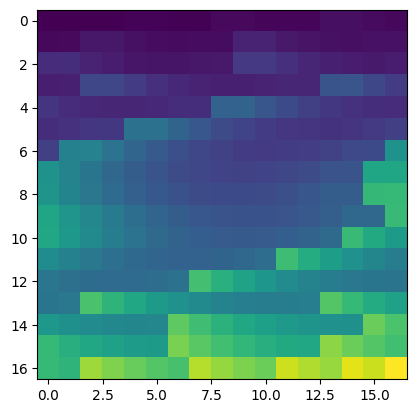

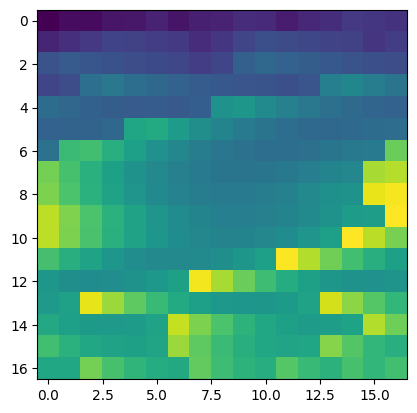

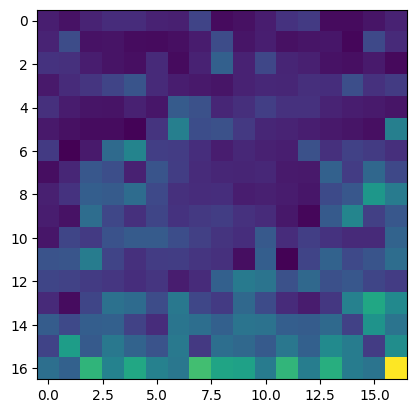

In [52]:
plt.imshow(np.vstack(T.data.U.values).reshape(-1,17))
plt.figure()
plt.imshow(U_m)
plt.figure()
plt.imshow(U_s)
#T.data.U.values.shape[0]**0.5

# PointNet

## Train debug

In [53]:
import torch
import pandas as pd
import sys

sys.path.append("../DL_models")
sys.path.append("../Transforms")
sys.path.append("..")

from Models.GAN import *
from Models.PointNet import *

def derivatives(u,x,n):
    if n==0:
        return u
    else:
        du=torch.autograd.grad(u,x,
        grad_outputs=torch.ones_like(u).to('cpu'),
        create_graph=True,
        retain_graph=True,
        allow_unused=True
        )[0]
    return derivatives(du,x,n-1)


In [54]:
M=General_architecture_GAN_PI(
    u_dim=1,
    G_expr='PointNetDenseCls(n_inputs=3,k=1,feature_transform=True)',
    P_expr='PointNetDenseCls(n_inputs=3,k=1,feature_transform=True)',
    D_expr='PointNetDenseCls(n_inputs=1,k=1,feature_transform=True)',
    args_Gen={"W_posterior":1.5},
    args_PDE_res={
        "R":(lambda u,x:-1*(derivatives(u,x,2)[:,0]+derivatives(u,x,2)[:,1])),
        "f":(lambda u,x:1+x[:,0]**2+2*x[:,1]**2),
        "norm":lambda x:torch.mean(torch.abs(x))
    },
    args_PDE_sup={
        "norm":lambda x:torch.mean(torch.abs(x))
    },
    distribution_args={"mean":torch.tensor([[0.0]]), "std":torch.tensor([[1.0]])},
    weights={"generative_posterior_loss":1.,
            "generative_entropy_loss":1.,
            "PDE_residual_loss":1.,
            "PDE_supervised_loss":1.}
)

PINNS_init


In [56]:
from Train import Dual_optimizer_trainer
from Data_transforms import group_U
T=Dual_optimizer_trainer(model_instance=M,
                       data_path="../Data/64x64_2D_poisson_eq_Dirichlet_BC.csv",
                       batch_size=200,
                       optimizer=(
                           torch.optim.Adam(M.D_model.parameters(),lr=1e-3),
                            torch.optim.Adam(list(M.G_model.parameters())+list(M.P_model.parameters()),lr=1e-3)
                            ),
                         data_dir="../Exps/Data_sensibility_exps/GAN_PI/GAN_PI_LL_s10_PDELL",
                       sub_steps=(1,5),
                         transform_U=(lambda d:[[d['u']]]),transform_X=(lambda d:[[d['x'],d['y']]]),
                         dataset_trasnform=(lambda x: group_U(x,5)),
                         scope_agent="generative_losses",
                    	scope_loss="PDE_supervised_loss",
                         fraction_list=[0.7,0.5,0.25]
                         #dataset_trasnform=None
                      )

In [ ]:
losses=T.epochs_train_test(10)

 60%|███████████████████████████████████████████████████████████████████████▍                                               | 6/10 [34:04<22:37, 339.45s/it]

In [13]:
#!ls ../Exps/Data_sensibility_exps/GAN_PI/GAN_PI_LL_s10_PDELL
res_70=np.load("../Exps/Data_sensibility_exps/GAN_PI/GAN_PI_LL_s10_PDELL/70_loss_results.npy",allow_pickle=True)

In [19]:
res_70.tolist()[0]

{'test': {'discriminative_losses': [{'generative_entropy_loss': tensor(-0.0539),
    'generative_posterior_loss': tensor(0.9859),
    'PDE_residual_loss': tensor(1.9554),
    'PDE_supervised_loss': tensor(2.1062),
    'Discriminator_loss': tensor(147.7171),
    'Generator_loss': tensor(1.2484),
    'total_loss': tensor(153.9590)}],
  'generative_losses': [{'generative_entropy_loss': tensor(-0.0685),
    'generative_posterior_loss': tensor(1.1278),
    'PDE_residual_loss': tensor(2.0794),
    'PDE_supervised_loss': tensor(2.1204),
    'Discriminator_loss': tensor(148.1956),
    'Generator_loss': tensor(1.3148),
    'total_loss': tensor(154.7695)},
   {'generative_entropy_loss': tensor(-0.0468),
    'generative_posterior_loss': tensor(0.6898),
    'PDE_residual_loss': tensor(2.0229),
    'PDE_supervised_loss': tensor(2.0977),
    'Discriminator_loss': tensor(148.2298),
    'Generator_loss': tensor(1.1909),
    'total_loss': tensor(154.1843)},
   {'generative_entropy_loss': tensor(-0.0678

In [18]:
#T.batch_size
epoch_losses=[]
for i in range(7):
    print(i)
    losses=T.train()
    epoch_losses.append(losses)

d_losses=list(map(lambda l:l['discriminative_losses'],epoch_losses))
g_losses=list(map(lambda l:l['generative_losses'],epoch_losses))

TypeError: 'int' object is not subscriptable

In [ ]:
#epoch_losses

import matplotlib.pyplot as plt
from functools import reduce
losses=reduce(lambda x,y:x+y, g_losses)
plt.plot(list(map(lambda l:l["generative_posterior_loss"].cpu().detach().numpy(),losses)))
plt.figure()
plt.plot(list(map(lambda l:l["generative_entropy_loss"].cpu().detach().numpy(),losses)))
plt.figure()
plt.plot(list(map(lambda l:l["Discriminator_loss"].cpu().detach().numpy(),losses)))
plt.figure()
plt.plot(list(map(lambda l:l["PDE_residual_loss"].cpu().detach().numpy(),losses)))
plt.figure()
plt.plot(list(map(lambda l:l["PDE_supervised_loss"].cpu().detach().numpy(),losses)))
plt.figure()
plt.plot(list(map(lambda l:l["total_loss"].cpu().detach().numpy(),losses)))

In [ ]:
list(map(lambda l:l["PDE_residual_loss"].cpu().detach().numpy(),losses))

## Results

In [4]:
import sys
sys.path.append("..")
from Train import Launch_train,Dual_optimizer_trainer
import json
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

In [5]:
LT=Launch_train()
LT.exp_data=json.load(open(os.path.join("../Exps/GAN_PI/GAN_PI__MultiP20_PointNet_LL_PDELL","config.json")))
LT.instantiate_model()

PINNS_init


In [6]:
LT.model.load_state_dict(torch.load("{fname}.pt".format(fname=os.path.join("../Exps/GAN_PI/GAN_PI__MultiP20_PointNet_LL_PDELL","best")), weights_only=True))


<All keys matched successfully>

In [7]:
T=Dual_optimizer_trainer(model_instance=LT.model,
                       data_path="../Data/2D_poisson_eq_Dirichlet_BC.csv",
                       batch_size=200,
                       optimizer=(
                           torch.optim.Adam(LT.model.D_model.parameters(),lr=1e-4),
                            torch.optim.Adam(list(LT.model.G_model.parameters())+list(LT.model.P_model.parameters()),lr=1e-4)
                            ),
                       sub_steps=(1,5),
                         transform_U="lambda d:[[d['u']]]",
                        transform_X="lambda d:[[d['x'],d['y']]]",
                      )

In [8]:
LT.model.eval()

General_architecture_GAN_PI(
  (G_model): PointNetDenseCls(
    (feat): PointNetfeat(
      (stn): STNkd(
        (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
        (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
        (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
        (fc1): Linear(in_features=1024, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (fc3): Linear(in_features=256, out_features=9, bias=True)
        (relu): ReLU()
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [29]:
UU_=[]
for i in range(50):
    U_=[]
    for x in T.data.X:
        x=torch.tensor(np.expand_dims(np.stack(x),0),dtype=torch.float)
        #x=torch.tensor(np.array(x),dtype=torch.float).unsqueeze(0)
        u_=LT.model.Generate_forward(x)
        U_.append(u_.detach().numpy()[0,0])
    UU_.append(np.array(U_).reshape(-1,17))

ValueError: cannot reshape array of size 1 into shape (17)

In [44]:
UU_=[]
for i in range(50):
    U_=[]
    u_=LT.model.Generate_forward(torch.tensor(np.stack(T.data.X.values),dtype=torch.float))
    UU_.append(u_.detach().numpy().reshape(-1,17))

In [46]:
U_m=np.mean(np.stack(UU_,axis=0),axis=0)
U_s=np.std(np.stack(UU_,axis=0),axis=0)

In [50]:
np.vstack(T.data.U.values).reshape(-1,17)

array([[1.        , 1.0078125 , 1.00390625, 1.01171875, 1.03125   ,
        1.03515625, 1.015625  , 1.0234375 , 1.0703125 , 1.07421875,
        1.046875  , 1.03515625, 1.04296875, 1.125     , 1.12890625,
        1.0859375 , 1.06640625],
       [1.0625    , 1.0703125 , 1.1953125 , 1.19921875, 1.140625  ,
        1.10546875, 1.09375   , 1.09765625, 1.10546875, 1.28125   ,
        1.28515625, 1.2109375 , 1.16015625, 1.1328125 , 1.12890625,
        1.140625  , 1.1484375 ],
       [1.3828125 , 1.38671875, 1.296875  , 1.23046875, 1.1875    ,
        1.16796875, 1.171875  , 1.19140625, 1.19921875, 1.5       ,
        1.50390625, 1.3984375 , 1.31640625, 1.2578125 , 1.22265625,
        1.2109375 , 1.22265625],
       [1.25      , 1.2578125 , 1.6328125 , 1.63671875, 1.515625  ,
        1.41796875, 1.34375   , 1.29296875, 1.265625  , 1.26171875,
        1.28125   , 1.31640625, 1.32421875, 1.78125   , 1.78515625,
        1.6484375 , 1.53515625],
       [1.4453125 , 1.37890625, 1.3359375 , 1.316406

In [52]:
U_s.reshape(-1,17)

array([[6.56988099e-02, 3.49248499e-02, 1.63401419e-03, 1.67408800e+00,
        1.32797110e+00, 2.31473222e-02, 2.87823323e-02, 2.39812568e-01,
        4.49782647e-02, 4.97539043e+00, 4.47412506e-02, 2.03153253e+00,
        5.26661539e+00, 1.33953318e-01, 1.44785806e-03, 3.07920258e-02,
        3.55502462e+00],
       [2.18269229e-03, 1.18354103e-02, 1.63417179e-02, 1.54617894e-02,
        2.21704555e+00, 2.25344911e-01, 1.53034604e+00, 1.06401992e+00,
        7.16431253e-03, 1.33179380e-02, 7.48978555e-03, 5.96821262e-03,
        5.67683876e-02, 1.34592518e-01, 7.46829947e-03, 8.09053611e-03,
        1.03594124e+00],
       [4.50978987e-02, 6.69698095e+00, 1.94272045e-02, 1.68596115e-02,
        2.82046571e-02, 5.72944343e-01, 2.77099013e-01, 2.46234681e-03,
        4.30155963e-01, 1.47117525e-01, 4.24817502e-02, 9.85997617e-02,
        6.62318289e-01, 3.08789396e+00, 1.24739138e-02, 1.98370206e+00,
        4.18316154e-03],
       [1.69118628e-01, 5.30241430e-01, 9.69514489e-01, 1.479

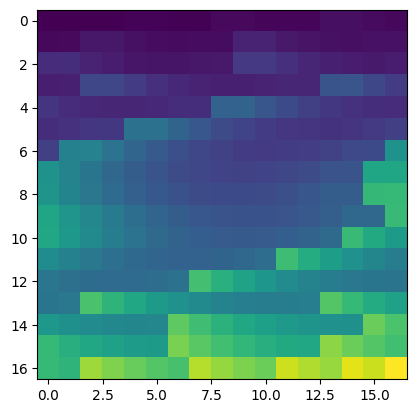

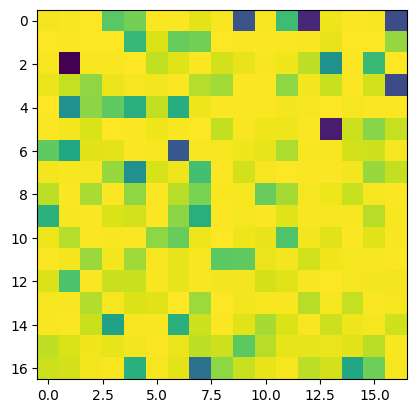

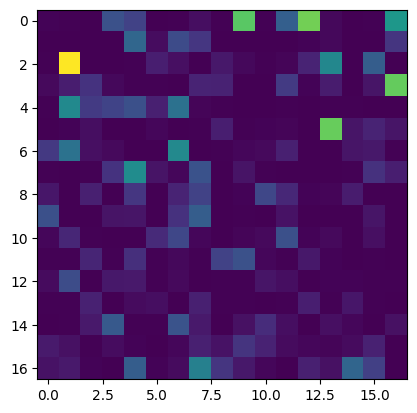

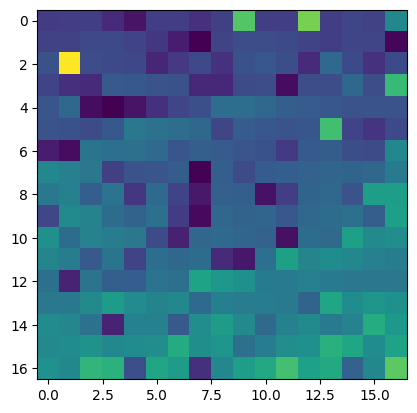

In [47]:
plt.imshow(np.vstack(T.data.U.values).reshape(-1,17))
plt.figure()
plt.imshow(U_m)
plt.figure()
plt.imshow(U_s)

plt.figure()
plt.imshow(np.abs(np.vstack(T.data.U.values).reshape(-1,17)-U_s))